In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages (will be added more as necessary)

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from numpy import sort

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")

In [4]:
# import framingham dataset and make dataframe
df = pd.read_csv('framingham.csv', delimiter = ',')

In [5]:
# high-level summary of the initial dataframe

# size(total # of data/cells)
df_size = df.size

# shape (row, column)
df_shape = df.shape

# # of array dimensions
df_ndim = df.ndim

# # of series for the dimension
df_sndim = df["TenYearCHD"].ndim

# Print dataframe summary
print("Size = ", df_size, "\nShape = ", df_shape, "\n# of array dimensions = ", df_ndim, "\n# of series for the dimension = ", df_sndim)

# view first 10 patient records
df.head(10)

Size =  67808 
Shape =  (4238, 16) 
# of array dimensions =  2 
# of series for the dimension =  1


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [6]:
# check how many patients are going to be diagnosed CHD in 10 years (response variable 'TenYearCHD')
df['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

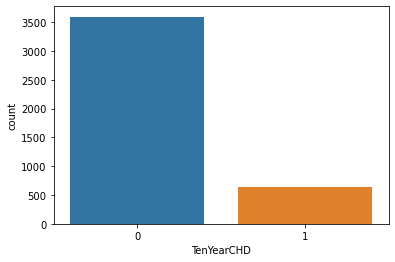

In [7]:
# show boxplot for the reponse variable. The dataset is not balanced
sb.countplot(data = df, x = "TenYearCHD")

In [8]:
#datatypes
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [9]:
# view empty data rows
df_null_data = df[df.isnull().any(axis=1)]
df_null_data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
14,0,39,2.0,1,9.0,0.0,0,0,0,226.0,114.0,64.0,22.35,85.0,NaN,0
21,0,43,1.0,0,0.0,0.0,0,0,0,185.0,123.5,77.5,29.89,70.0,NaN,0
26,0,60,1.0,0,0.0,0.0,0,0,0,260.0,110.0,72.5,26.59,65.0,NaN,0
33,1,61,NaN,1,5.0,0.0,0,0,0,175.0,134.0,82.5,18.59,72.0,75.0,1
36,1,56,NaN,0,0.0,0.0,0,0,0,257.0,153.5,102.0,28.09,72.0,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,0,51,1.0,1,9.0,0.0,0,0,0,340.0,152.0,76.0,25.74,70.0,NaN,0
4229,0,51,3.0,1,20.0,0.0,0,1,0,251.0,140.0,80.0,25.60,75.0,NaN,0
4230,0,56,1.0,1,3.0,0.0,0,1,0,268.0,170.0,102.0,22.89,57.0,NaN,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0


In [10]:
# check duplicate patient records
df[df.duplicated()]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


In [11]:
df.duplicated().sum()

0

In [12]:
# check null data in the dataset
df.isnull().sum()

# replace blank cells with 'NaN'
df.replace(r'^\s*$', np.NaN, regex=True)

# check again
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


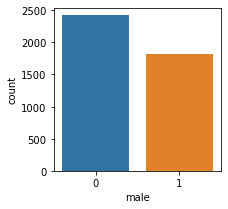

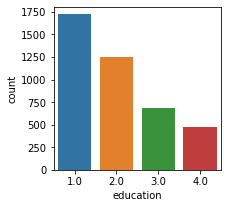

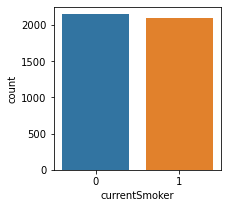

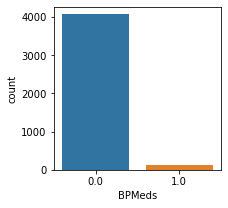

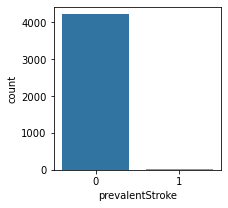

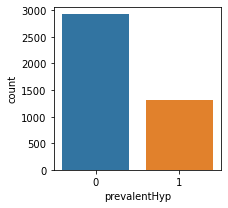

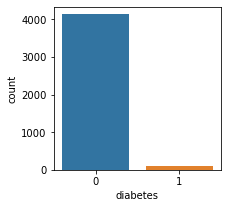

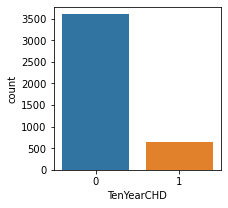

In [14]:
# show bar graphs for all categorical features (nominal)

df_categ = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

# for loop to display all selected features in df_nominal

for x in df_categ:
    plt.figure(figsize = (3,3))
    sb.countplot(df[x])
    plt.show()
    

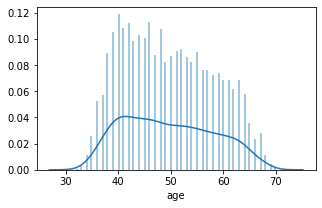

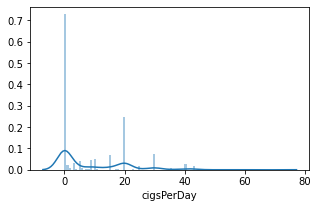

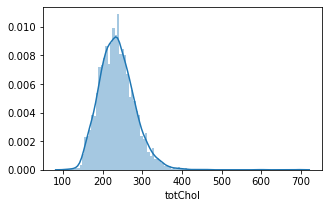

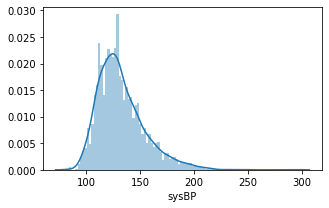

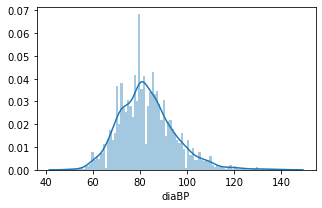

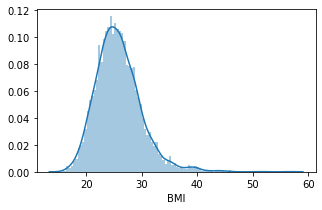

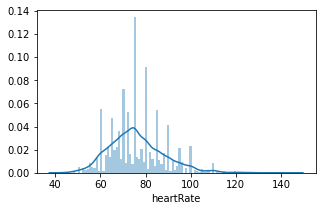

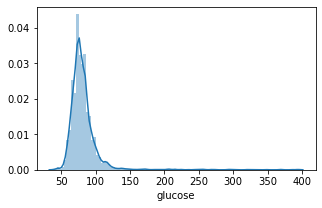

In [15]:
# show distribution graphs for all numerical features (continous)

df_contin = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

# for loop to display all selected features in df_nominal

for x in df_contin:
    plt.figure(figsize = (5,3))
    sb.distplot(df[x], bins = 100)
    plt.show()

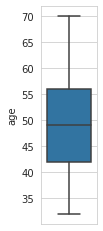

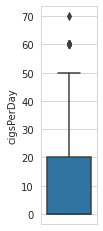

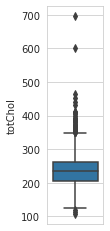

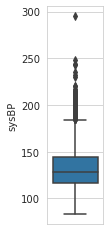

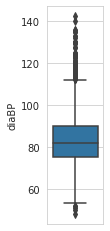

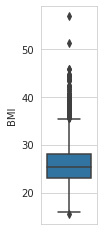

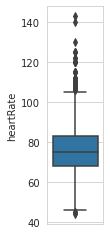

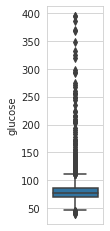

In [16]:
# create and show a set of boxplots for each numerical feature

# ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

for i in df_contin:
    plt.figure(figsize=(1,4))
    sb.set_style("whitegrid")
    sb.boxplot(y = df[i])
    plt.show()

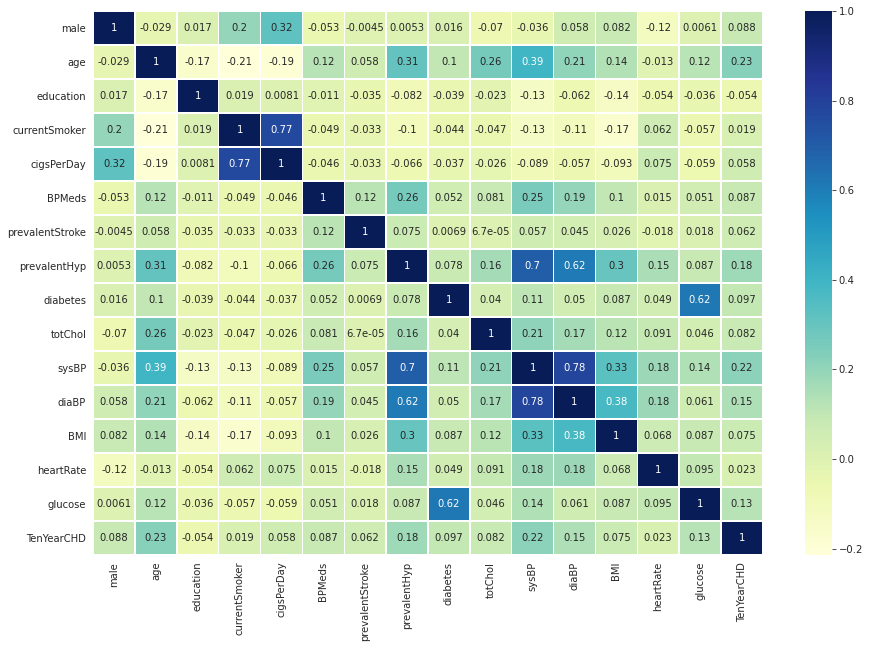

In [17]:
## show correlation plot to check correlation of the features
plt.subplots(figsize=(15,10))
sb.heatmap(df.corr(), cmap = "YlGnBu", annot = True, linewidths=.5)

Data Cleaning

In [18]:
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [19]:
# Using KNNImputer to impute the missing null values. KNN method to fill the null/missing values
# We previously removed the outliers, so KNN is not sensitive to outliers anymore
# KNN to predict the most frequent value for discrete attributes, or the mean for the continous attributes - among the k nearest neighbors

# Define a dataframe of selected features that contain null values

null_list = []
for i in df:
    
    if (df[i].isnull().sum()) > 0 :
        null_list.append(i)
    
print("Features with null values: ", null_list)


# Extract the null list of features from the original datagrame and assign into a new dataframe

df_null_cols = df[null_list]

list(df_null_cols)


Features with null values:  ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']


['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

In [20]:
# Initialize/define KNNImputer n_neighbor value of '1'

imputer = KNNImputer(n_neighbors = 1)


# impute the knn to the null values

df_imputed = imputer.fit_transform(df_null_cols)

df_imputed = pd.DataFrame(df_imputed, columns = [null_list])

# Now the KNN imputed dataframe should have no null values
df_imputed.isnull().sum()

education     0
cigsPerDay    0
BPMeds        0
totChol       0
BMI           0
heartRate     0
glucose       0
dtype: int64

In [21]:
df_imputed.head()

,education,cigsPerDay,BPMeds,totChol,BMI,heartRate,glucose
0,4.0,0.0,0.0,195.0,26.97,80.0,77.0
1,2.0,0.0,0.0,250.0,28.73,95.0,76.0
2,1.0,20.0,0.0,245.0,25.34,75.0,70.0
3,3.0,30.0,0.0,225.0,28.58,65.0,103.0
4,3.0,23.0,0.0,285.0,23.10,85.0,85.0


In [22]:
# Now replace the imputed attributes with imputed data with the origianl dataframe data

# Remove the null columns/data from the original outlier-treated dataframe

df_out = df.drop(['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose'], axis = 1)

df_out.head()

,male,age,currentSmoker,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,TenYearCHD
0,1,39,0,0,0,0,106.0,70.0,0
1,0,46,0,0,0,0,121.0,81.0,0
2,1,48,1,0,0,0,127.5,80.0,0
3,0,61,1,0,1,0,150.0,95.0,1
4,0,46,1,0,0,0,130.0,84.0,0


In [23]:
# Concatenate with imputed columns and data

df_out.reset_index(drop = True, inplace = True)
df_imputed.reset_index(drop = True, inplace = True)

df_impute = pd.concat([df_out, df_imputed], axis = 1)

In [24]:
df_impute.head()

,male,age,currentSmoker,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,TenYearCHD,"(education,)","(cigsPerDay,)","(BPMeds,)","(totChol,)","(BMI,)","(heartRate,)","(glucose,)"
0,1,39,0,0,0,0,106.0,70.0,0,4.0,0.0,0.0,195.0,26.97,80.0,77.0
1,0,46,0,0,0,0,121.0,81.0,0,2.0,0.0,0.0,250.0,28.73,95.0,76.0
2,1,48,1,0,0,0,127.5,80.0,0,1.0,20.0,0.0,245.0,25.34,75.0,70.0
3,0,61,1,0,1,0,150.0,95.0,1,3.0,30.0,0.0,225.0,28.58,65.0,103.0
4,0,46,1,0,0,0,130.0,84.0,0,3.0,23.0,0.0,285.0,23.10,85.0,85.0


In [25]:
df_impute.isnull().sum()

male               0
age                0
currentSmoker      0
prevalentStroke    0
prevalentHyp       0
diabetes           0
sysBP              0
diaBP              0
TenYearCHD         0
(education,)       0
(cigsPerDay,)      0
(BPMeds,)          0
(totChol,)         0
(BMI,)             0
(heartRate,)       0
(glucose,)         0
dtype: int64

In [26]:
# Rename the columns to correct the columns
df_impute.columns = ['male','age','currentSmoker','prevalentStroke','prevalentHyp','diabetes','sysBP','diaBP','TenYearCHD','education','cigsPerDay','BPMeds','totChol','BMI','heartRate','glucose']

In [27]:
# Rearrange columns
df_impute = df_impute[['male','age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]

In [28]:
df_impute

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,102.0,0


Data Normalization

# Normalize the data

In [29]:
df_impute

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,102.0,0


In [30]:
print (df)

      male  age  education  currentSmoker  cigsPerDay  BPMeds  \
0        1   39        4.0              0         0.0     0.0   
1        0   46        2.0              0         0.0     0.0   
2        1   48        1.0              1        20.0     0.0   
3        0   61        3.0              1        30.0     0.0   
4        0   46        3.0              1        23.0     0.0   
...    ...  ...        ...            ...         ...     ...   
4233     1   50        1.0              1         1.0     0.0   
4234     1   51        3.0              1        43.0     0.0   
4235     0   48        2.0              1        20.0     NaN   
4236     0   44        1.0              1        15.0     0.0   
4237     0   52        2.0              0         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    195.0  106.0   70.0  26.97   
1                   0             0         0    250.0  121.0

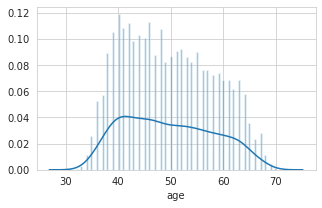

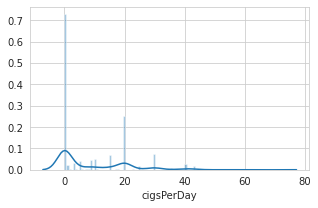

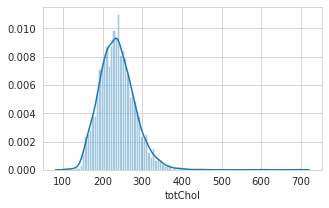

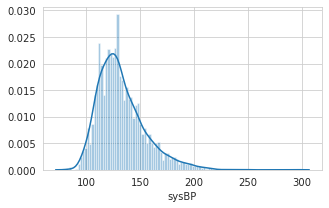

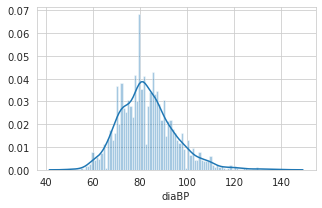

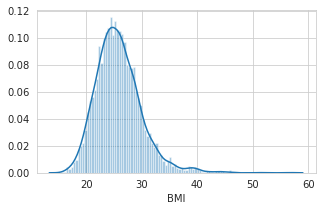

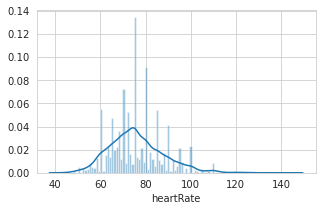

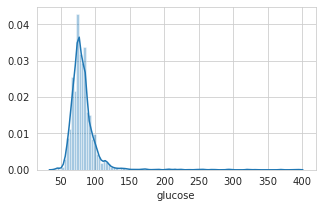

In [31]:
# show distribution graphs for all numerical features (continous)

df_contin = df_impute[['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

# for loop to display all selected features in df_nominal

for x in df_contin:
    plt.figure(figsize = (5,3))
    sb.distplot(df_contin[x], bins = 100)
    plt.show()

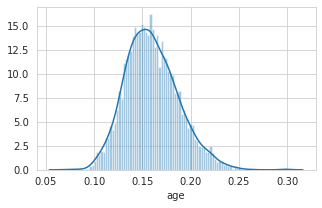

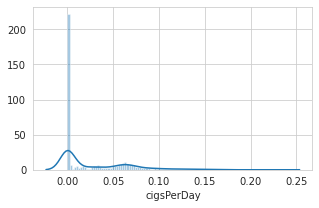

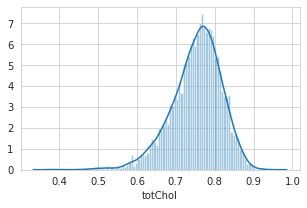

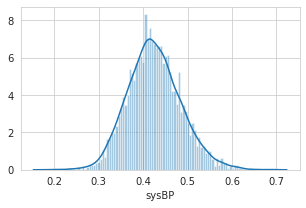

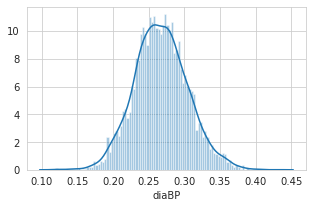

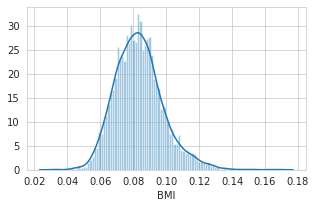

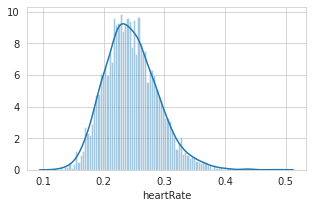

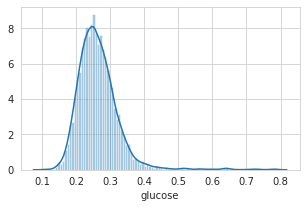

In [32]:
d = preprocessing.normalize(df_impute[['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']])
df_scaled = pd.DataFrame(d, columns = ['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'])

for x in df_scaled:
    plt.figure(figsize = (5,3))
    sb.distplot(df_scaled[x], bins = 100)
    plt.show()


In [33]:
# Now replace the normalized attributes with the origianl dataframe data

# Remove the normalized columns from the original dataframe

df_drop = df_impute.drop(['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], axis = 1)

df_drop.head()

,male,education,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD
0,1,4.0,0,0.0,0,0,0,0
1,0,2.0,0,0.0,0,0,0,0
2,1,1.0,1,0.0,0,0,0,0
3,0,3.0,1,0.0,0,1,0,1
4,0,3.0,1,0.0,0,0,0,0


In [34]:
# Concatenate with scaled columns and original data

df_drop.reset_index(drop = True, inplace = True)
df_scaled.reset_index(drop = True, inplace = True)

df_new = pd.concat([df_drop, df_scaled], axis = 1)

df_new.head()

,male,education,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,4.0,0,0.0,0,0,0,0,0.148753,0.000000,0.743764,0.404302,0.266992,0.102868,0.305134,0.293691
1,0,2.0,0,0.0,0,0,0,0,0.144425,0.000000,0.784921,0.379902,0.254314,0.090203,0.298270,0.238616
2,1,1.0,1,0.0,0,0,0,0,0.154476,0.064365,0.788469,0.410326,0.257459,0.081550,0.241368,0.225277
3,0,3.0,1,0.0,0,1,0,1,0.190605,0.093740,0.703050,0.468700,0.296843,0.089303,0.203103,0.321841
4,0,3.0,1,0.0,0,0,0,0,0.131263,0.065631,0.813259,0.370960,0.239697,0.065917,0.242551,0.242551


In [35]:
# Rearrange the order of the columns

df_new = df_new[['male','age','education','currentSmoker','cigsPerDay','BPMeds','prevalentStroke','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose','TenYearCHD']]
df_new.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,0.148753,4.0,0,0.000000,0.0,0,0,0,0.743764,0.404302,0.266992,0.102868,0.305134,0.293691,0
1,0,0.144425,2.0,0,0.000000,0.0,0,0,0,0.784921,0.379902,0.254314,0.090203,0.298270,0.238616,0
2,1,0.154476,1.0,1,0.064365,0.0,0,0,0,0.788469,0.410326,0.257459,0.081550,0.241368,0.225277,0
3,0,0.190605,3.0,1,0.093740,0.0,0,1,0,0.703050,0.468700,0.296843,0.089303,0.203103,0.321841,1
4,0,0.131263,3.0,1,0.065631,0.0,0,0,0,0.813259,0.370960,0.239697,0.065917,0.242551,0.242551,0


# Treating Outliers

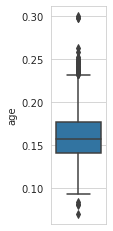

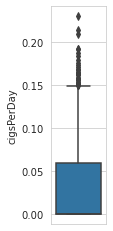

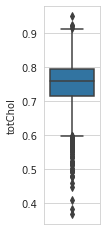

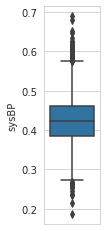

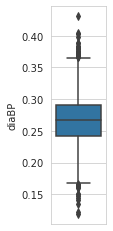

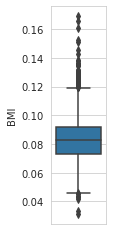

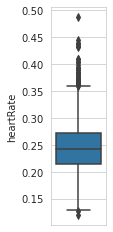

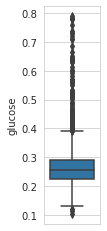

In [36]:
#Display boxplots for all continous features and visulize the outliers

df_contin = df_new[['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

for i in df_contin:
    plt.figure(figsize=(1,4))
    sb.set_style("whitegrid")
    sb.boxplot(y = df_contin[i])
    plt.show()

In [37]:
# First method: Identify and remove rows that contain outlier data using IQR score. Outlier: Data below or above 25th or 75th percentile
# Anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier

# Find IQR for each feature
Q1 = df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

male               1.000000
age                0.036674
education          2.000000
currentSmoker      1.000000
cigsPerDay         0.059531
BPMeds             0.000000
prevalentStroke    0.000000
prevalentHyp       1.000000
diabetes           0.000000
totChol            0.079204
sysBP              0.076340
diaBP              0.049602
BMI                0.018402
heartRate          0.057574
glucose            0.066722
TenYearCHD         0.000000
dtype: float64


In [38]:
# We will treat/remove the remove outliers if not in the IQR range mentioned above (below 25th and above 75th)

df_0 = df_new[~((df_new['age'] < (Q1['age'] - 1.5 * IQR['age'])) | ((df_new['age'] > (Q3['age'] + 1.5 * IQR['age']))))]
df_1 = df_0[~((df_0['totChol'] < (Q1['totChol'] - 1.5 * IQR['totChol'])) | ((df_0['totChol'] > (Q3['totChol'] + 1.5 * IQR['totChol']))))]
df_2 = df_1[~((df_1['sysBP'] < (Q1['sysBP'] - 1.5 * IQR['sysBP'])) | ((df_1['sysBP'] > (Q3['sysBP'] + 1.5 * IQR['sysBP']))))]
df_3 = df_2[~((df_2['diaBP'] < (Q1['diaBP'] - 1.5 * IQR['diaBP'])) | ((df_2['diaBP'] > (Q3['diaBP'] + 1.5 * IQR['diaBP']))))]
df_4 = df_3[~((df_3['BMI'] < (Q1['BMI'] - 1.5 * IQR['BMI'])) | ((df_3['BMI'] > (Q3['BMI'] + 1.5 * IQR['BMI']))))]
df_5 = df_4[~((df_4['heartRate'] < (Q1['heartRate'] - 1.5 * IQR['heartRate'])) | ((df_4['heartRate'] > (Q3['heartRate'] + 1.5 * IQR['heartRate']))))]
df_6 = df_5[~((df_5['glucose'] < (Q1['glucose'] - 1.5 * IQR['glucose'])) | ((df_5['glucose'] > (Q3['glucose'] + 1.5 * IQR['glucose']))))]
df_out = df_6[~((df_6['cigsPerDay'] < (Q1['cigsPerDay'] - 1.5 * IQR['cigsPerDay'])) | ((df_6['cigsPerDay'] > (Q3['cigsPerDay'] + 1.5 * IQR['cigsPerDay']))))]

print("Number of orignal records: ", len(df_new))
print("Number of orignal minus outliers: ", len(df_out))
print("Total outliers deleted using the IQR method: ", len(df_new)-len(df_out))

Number of orignal records:  4238
Number of orignal minus outliers:  3848
Total outliers deleted using the IQR method:  390


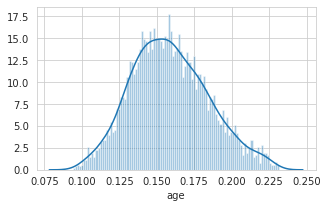

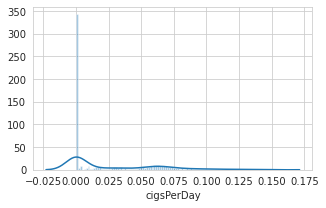

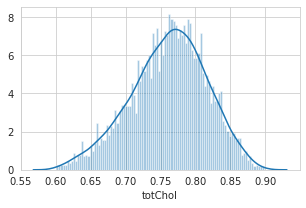

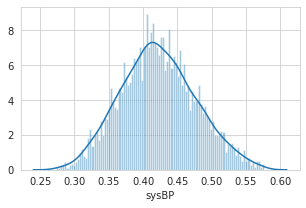

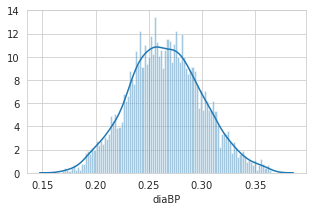

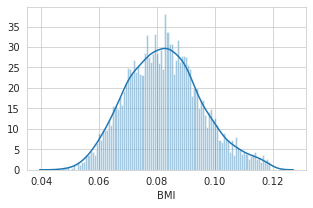

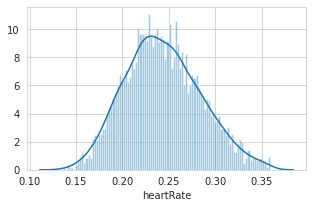

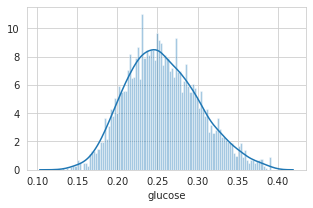

In [39]:
#First method distribution

# show distribution graphs for all numerical features (continous)

df_contin = df_out[['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

for x in df_contin:
    plt.figure(figsize = (5,3))
    sb.distplot(df_contin[x], bins = 100)
    plt.show()

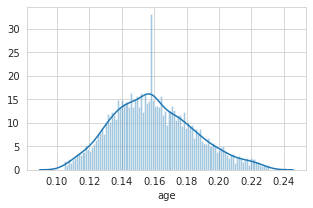

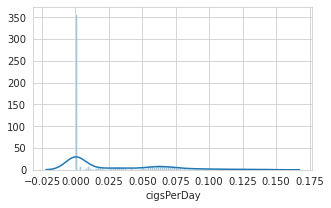

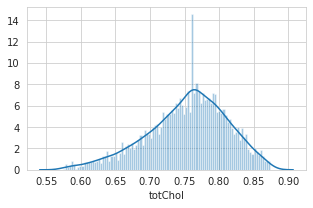

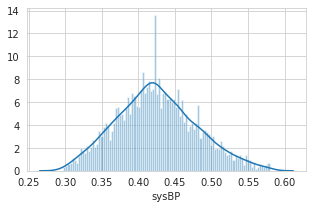

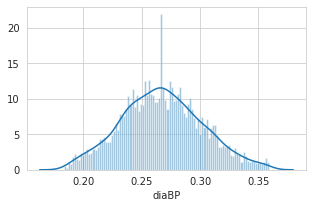

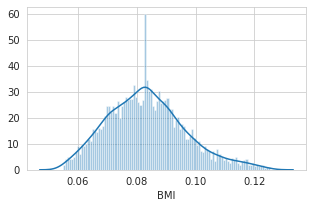

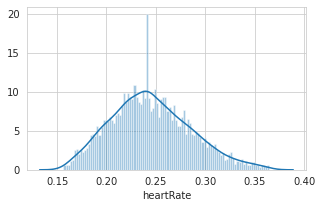

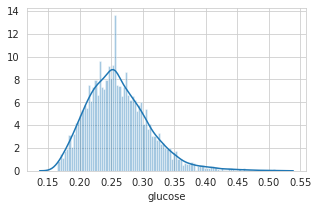

In [40]:
# Second method: Treat outliers below 1st and 99th with median value

df_med = df_new[['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

for x in df_med:
    df_med[x] = np.where(df_med[x] > df_med[x].quantile(0.99), df_med[x].quantile(0.50), df_med[x])
    df_med[x] = np.where(df_med[x] < df_med[x].quantile(0.01), df_med[x].quantile(0.50), df_med[x])

#2nd method distribution    

for x in df_med:
    plt.figure(figsize = (5,3))
    sb.distplot(df_med[x], bins = 100)
    plt.show()

* IQR method is best suited to treat the outliers, due to each feature containing too many outliers. even with 1st percentile and 99th outlier-picking Median method would not properly normally distrubte the data in the features.

# Feature Selection
* Methods: 1) Correlation Matrix (Correlation Heat map) 2) XGBoost Feature Importance 3) Random Forest
* Feature Selection

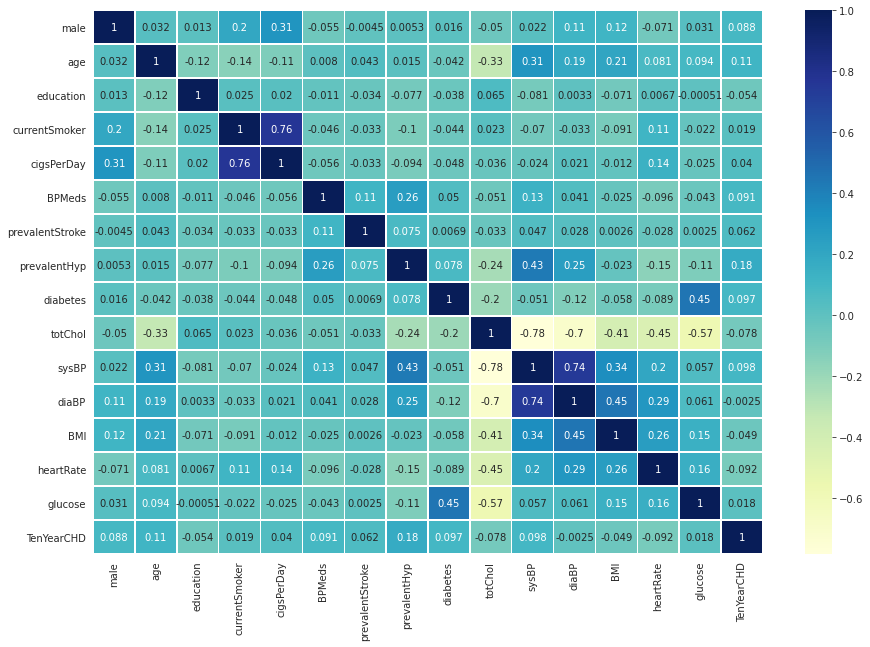

In [41]:
# 1) show correlation plot to check correlation of the features
plt.subplots(figsize=(15,10))
sb.heatmap(df_new.corr(), cmap = "YlGnBu", annot = True, linewidths=.5)

* Highly Correlated: sysBP & diaBP (0.76),  cigsPerDay & currentSmoker (0.74)
* Moderately Correlatedd: sysBP & prevalentHyp (0.43), diabetes & glucose (0.45)
* Lowly Correlated: BPMeds & prevalentHyp(0.26), diaBP & prevalentHyp (0.25), sysBP & age (0.31), male & cigsPerDay (0.31), sysBP & BMI (0.34), heartRate & BMI (0.29), sysBP & heartRate (0.2), BMI & glucose (0.15), heartRate & glucose (0.16)

In [42]:
# 2) XGBoost Feature Importance

# build train data
df_train = df_new


# Split data into training features and labels
X, y = df_train.loc[:, df_train.columns != 'TenYearCHD'],df_train['TenYearCHD']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators = 100, max_depth=5)
model.fit(X_train, y_train)

# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("XG Boost Test Accuracy: %.2f%%" % (accuracy * 100.0))

# make predictions for train set
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train, predictions)
print("XG Boost Train Accuracy: %.2f%%" % (accuracy * 100.0))

[21:41:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG Boost Test Accuracy: 85.61%
XG Boost Train Accuracy: 88.14%


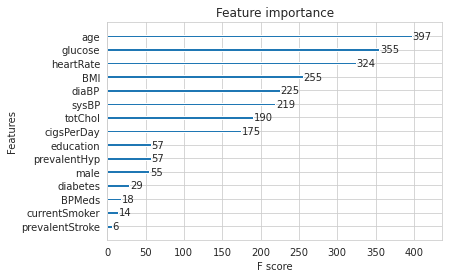

In [43]:
# plot XG Boost feature importance

plot_importance(model)

In [44]:
# 3) Random Forest Importance

# build train data
df_train = df_new

# Split data into training features and labels
X, y = df_train.loc[:, df_train.columns != 'TenYearCHD'],df_train['TenYearCHD']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Instantiate model and train
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)


# make predictions for test set
y_pred = rf.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Random Forest Test Accuracy: %.2f%%" % (accuracy * 100.0))

# make predictions for train set
y_pred = rf.predict(X_train)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train, predictions)
print("Random Forest Train Accuracy: %.2f%%" % (accuracy * 100.0))

Random Forest Test Accuracy: 84.55%
Random Forest Train Accuracy: 100.00%


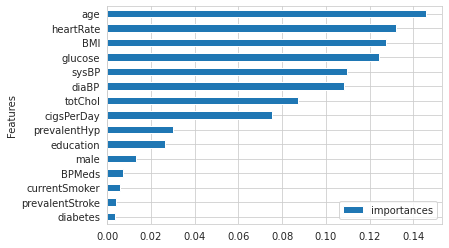

In [45]:
# plot RF feature importance

dfr = pd.DataFrame({'Features':X_train.columns, 'importances':rf.feature_importances_})
dfr.sort_values('importances',inplace=True)
dfr.plot(kind='barh', y='importances', x='Features')

* Feature Importance

* Based on the previous correlation heat map result:

* Highly Correlated: sysBP & diaBP (0.76),  cigsPerDay & currentSmoker (0.74)
* Moderately Correlatedd: sysBP & prevalentHyp (0.43), diabetes & glucose (0.45)
* Lowly Correlated: BPMeds & prevalentHyp(0.26), diaBP & prevalentHyp (0.25), sysBP & age (0.31), male & cigsPerDay (0.31), sysBP & BMI (0.34), heartRate & BMI (0.29), sysBP & heartRate (0.2), BMI & glucose (0.15), heartRate & glucose (0.16)

Based on all the findings from all the feature selection methods, we will drop diaBP, prevalentHyp, education, male, diabetes, BPMeds, currentSmoker, prevalentStroke, and then we will keep the top  features from the rest of the score summary.

In [46]:
# New DF with Selected Top Feature
df_feat = pd.DataFrame(df_new, columns = ['age','cigsPerDay','totChol','sysBP','BMI','heartRate','glucose','TenYearCHD'])

# Split Train & Test (K-fold Cross validation), and Class Balancing (Over-Sampling)

* k-Fold cross-validation is used to split the data into Train and Test set.
* k-Fold cross validation produces less variance and results in reduced bias in the estimates of models. This works by dividing the dataset into 10 parts, hold out each part in turn, and average out the results.
* Each data point in the dataset is used once for testing and k-1 times for training.


* We will be oversampling method to prevent reducing any more data samples in our dataframe. Oversampling : duplicate samples of the minority TenYearCHD class. To mitigate overfitting caused by random oversampling

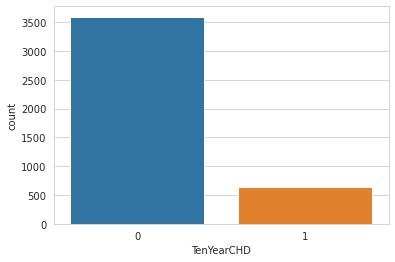

In [47]:
# Plot the graph
sb.countplot(data = df_feat, x = "TenYearCHD")

In [48]:
# Check the imbalanced class
df_feat['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

In [49]:
# First we split data into independent/target features and labels
X, y = df_feat.loc[:, df_feat.columns != 'TenYearCHD'],df_feat['TenYearCHD']

# Implementing cross validation,k = 10
k = 10
kf = KFold(n_splits = k, random_state = None)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    #print('Train: %s, Test: %s' % (X[train], X[test]))
    #print("Train", train_index, "Test:", test_index)


# Apply SMOTE to train independent(X) features and the target (y)
# And store the results in dedicated variables.
# The new feature and target set should be larger, due to oversampling.

sm = SMOTE(random_state = 42)

X_train, y_train = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_train.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train.value_counts(normalize = True) * 100

Shape of X before SMOTE: (4238, 7)
Shape of X after SMOTE: (6480, 7)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TenYearCHD, dtype: float64

In [50]:
# Check the SMOTE-treated class
y_train.value_counts()

1    3240
0    3240
Name: TenYearCHD, dtype: int64

In [51]:
# Concatenate X and y

df_sm = pd.concat([X_train, y_train], axis = 1)

df_sm.describe()

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000
mean,0.162809,0.030928,0.747575,0.431758,0.083064,0.241729,0.265200,0.500000
std,0.027363,0.038923,0.068097,0.064209,0.014252,0.042795,0.070569,0.500039
min,0.069661,0.000000,0.368188,0.187008,0.031326,0.119863,0.103300,0.000000
25%,0.143358,0.000000,0.707916,0.387673,0.073392,0.211524,0.223602,0.000000
50%,0.161475,0.005845,0.755978,0.426573,0.082394,0.237586,0.254544,0.500000
75%,0.180367,0.060432,0.794073,0.473134,0.091181,0.268841,0.289921,1.000000
max,0.300114,0.230257,0.950669,0.689557,0.168974,0.445915,0.789106,1.000000


# Predictive Modelling and Evaluation (with K-fold cross validation)
* Each model result is then presented by Confusion Matrix Score and Area Under The Curve - Receiver Operating Characteristics curve (AUC - ROC)
* AUC meausres the model performance based on TP and FP rate.
* Higher the AUC (closer to -> 1), the better the model is at distinguishing between patients with TenYearCHD or not.

Accuracy = 0.69
Recall = 0.28
Precision = 0.19
F1 = 0.22



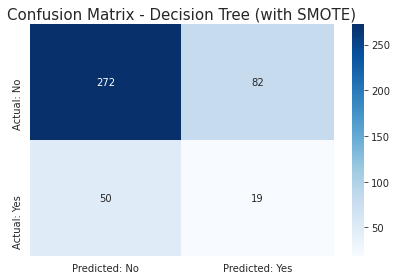

In [52]:
# 1) Decision Tree

# Initilize and fit Decision Tree model into the train/test dataset
dct = DecisionTreeClassifier().fit(X_train, y_train)
dct_pred = dct.predict(X_test)

# Define matrix scores for the model
acc = accuracy_score(y_test, dct_pred)
recall = recall_score(y_test, dct_pred)
precision = precision_score(y_test, dct_pred)
f1 = f1_score(y_test, dct_pred)


# Print the result
print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')

# Plot Confusion Matrix
c = confusion_matrix(y_test, dct_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - Decision Tree (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

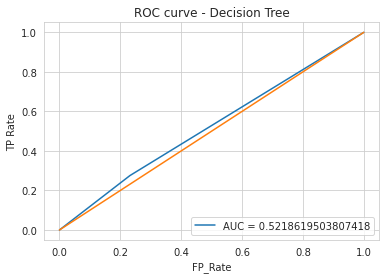

In [53]:
# AUC - Decision Tree

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, dct_pred)
auc = roc_auc_score(y_test, dct_pred)

plt.title ('ROC curve - Decision Tree')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()


Accuracy = 0.65
Recall = 0.62
Precision = 0.26
F1 = 0.37



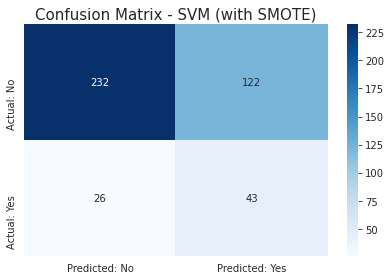

In [54]:
# 2) Support Vector Model (SVM)

# Initilize and fit SVM model into the train/test dataset

svm = SVC().fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Define matrix scores for the model

acc = accuracy_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred)
f1 = f1_score(y_test, svm_pred)


# Print the result

print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')


# Plot Confusion Matrix

c = confusion_matrix(y_test, svm_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - SVM (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

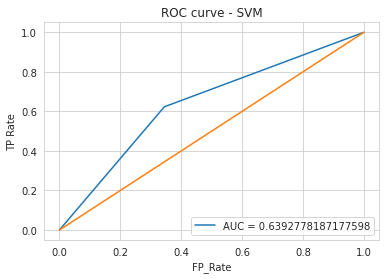

In [55]:
# AUC - SVM

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, svm_pred)
auc = roc_auc_score(y_test, svm_pred)

plt.title ('ROC curve - SVM')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()

[21:41:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.67
Recall = 0.42
Precision = 0.23
F1 = 0.30



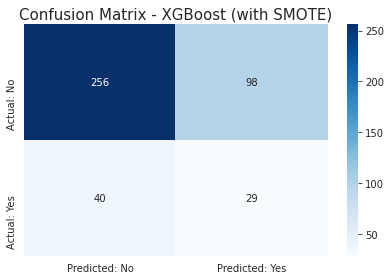

In [56]:
# 3) XGBoost Model

# Initilize and fit XGBoost model into the train/test dataset

xgb = XGBClassifier(learning_rate = 0.05, colsample_bynode = 0.8, subsample = 0.8)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Define matrix scores for the model

acc = accuracy_score(y_test, xgb_pred)
recall = recall_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred)
f1 = f1_score(y_test, xgb_pred)


# Print the result

print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')


# Plot Confusion Matrix

c = confusion_matrix(y_test, xgb_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - XGBoost (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

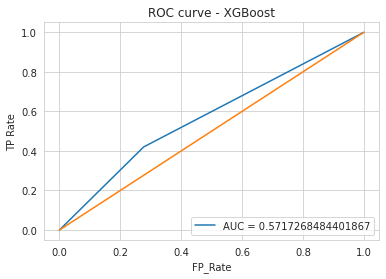

In [57]:
# AUC - XGBoost

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, xgb_pred)
auc = roc_auc_score(y_test, xgb_pred)

plt.title ('ROC curve - XGBoost')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()

Accuracy = 0.72
Recall = 0.23
Precision = 0.19
F1 = 0.21



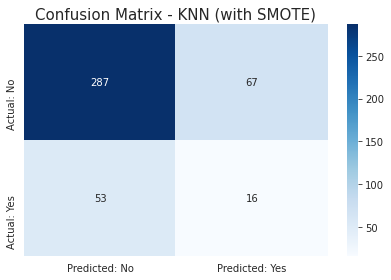

In [58]:
# 4) KNN Model

# Initilize and fit KNN model into the train/test dataset

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# Define matrix scores for the model

acc = accuracy_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)
precision = precision_score(y_test, knn_pred)
f1 = f1_score(y_test, knn_pred)


# Print the result

print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')


# Plot Confusion Matrix

c = confusion_matrix(y_test, knn_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - KNN (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

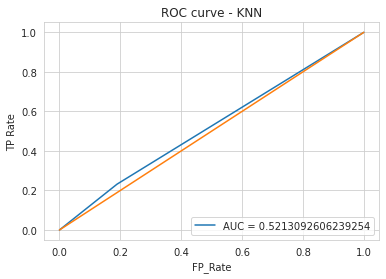

In [59]:
# AUC - KNN

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, knn_pred)
auc = roc_auc_score(y_test, knn_pred)

plt.title ('ROC curve - KNN')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()

Accuracy = 0.61
Recall = 0.55
Precision = 0.22
F1 = 0.32



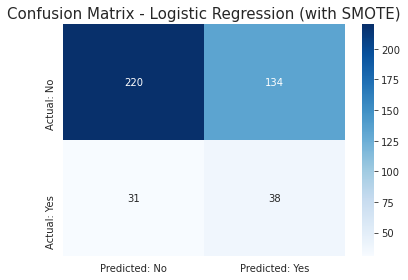

In [60]:
# 5) Logistic Regression

# Initilize and fit Logistic Regression model into the train/test dataset

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_pred = lgr.predict(X_test)

# Define matrix scores for the model

acc = accuracy_score(y_test, lgr_pred)
recall = recall_score(y_test, lgr_pred)
precision = precision_score(y_test, lgr_pred)
f1 = f1_score(y_test, lgr_pred)


# Print the result

print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')


# Plot Confusion Matrix

c = confusion_matrix(y_test, lgr_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - Logistic Regression (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

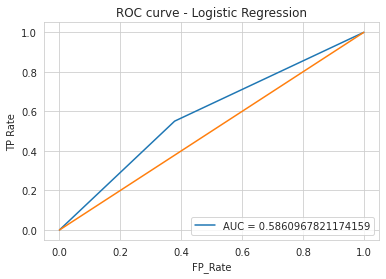

In [61]:
# AUC - Logistic Regression

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, lgr_pred)
auc = roc_auc_score(y_test, lgr_pred)

plt.title ('ROC curve - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()

Accuracy = 0.76
Recall = 0.32
Precision = 0.28
F1 = 0.30



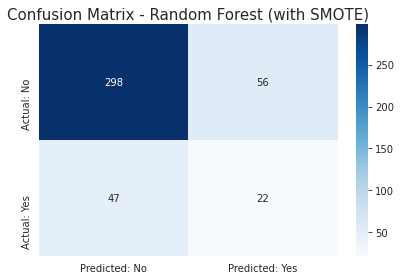

In [62]:
# 6) Random Forest Model

# Initilize and fit Random Forest model into the train/test dataset

rft = RandomForestClassifier(class_weight='balanced', n_estimators = 100, max_features='auto')
rft.fit(X_train, y_train)
rft_pred = rft.predict(X_test)

# Define matrix scores for the model

acc = accuracy_score(y_test, rft_pred)
recall = recall_score(y_test, rft_pred)
precision = precision_score(y_test, rft_pred)
f1 = f1_score(y_test, rft_pred)


# Print the result

print(f'Accuracy = {acc:.2f}\nRecall = {recall:.2f}\nPrecision = {precision:.2f}\nF1 = {f1:.2f}\n')


# Plot Confusion Matrix

c = confusion_matrix(y_test, rft_pred)
c_mat = pd.DataFrame(data = c,columns=['Predicted: No','Predicted: Yes'],index=['Actual: No','Actual: Yes'])
plt.title('Confusion Matrix - Random Forest (with SMOTE)', size = 15)
plt.tight_layout()
sb.heatmap(c_mat, annot = True, cmap = 'Blues', fmt = 'g');

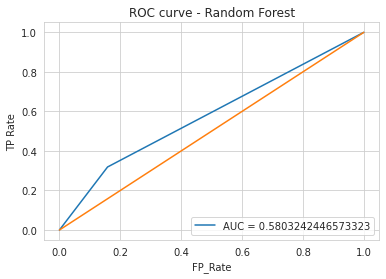

In [63]:
# AUC - Random Forest

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, rft_pred)
auc = roc_auc_score(y_test, rft_pred)

plt.title ('ROC curve - Random Forest')
plt.plot(false_positive_rate, true_positive_rate, label= "AUC = " + str(auc))
plt.legend(loc = 4)
plt.plot([0,1])
plt.ylabel('TP Rate')
plt.xlabel('FP_Rate')
plt.show()